In [1]:

import brainpy.math as bm
import numpy as np
from PCCAN_utils import get_tuningMap, animate_sweeps
from models import PC_cell_topdown, PC_cell_topdown_asym

#for generting behavioral trajectory
from ratinabox.Environment import Environment
from ratinabox.Agent import Agent

#for plotting
import matplotlib.pyplot as plt
#grid spec
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import seaborn as sns
import time

import os
from scipy.signal import find_peaks
from scipy.ndimage import center_of_mass
from scipy.stats import pearsonr

import sys
sys.path.append('/home/zilong/Desktop/HoneycombSweeps/CircularLinearReg')
from core import cl_corr


%matplotlib inline  
%load_ext autoreload 
%autoreload 2

[]

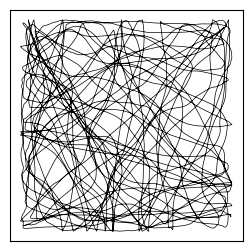

: 

In [2]:
np.random.seed(111)

Env = Environment(params={
    'scale':1,
    "dimensionality": "2D",
})

dur = 400 #in seconds
dt = 0.001 #in seconds
speed_mean = 0.2 #in m/s
speed_std = 0.0 #in m/s
rot = 60
rotation_velocity_std = rot * (np.pi / 180) #in rad/s

#if traj exist, load it, otherwise generate it
if os.path.exists('./traces/Traj_dur'+str(dur)+'_speedMean'+str(speed_mean)+'_rot'+str(rot)+'.npz'):
    data = np.load('./traces/Traj_dur'+str(dur)+'_speedMean'+str(speed_mean)+'_rot'+str(rot)+'.npz')
    Position = data['Position'] #add 0,5 is to make the running rat in the middle of the box [from 0.5 to 1.5], the size of the neuronal sheet is 2by2. we did so to remove the periodic boundary effect
    Speed = data['Speed']
    Vel = data['Velocity']
else:
    Ag = Agent(Env, params = {
        "dt": dt,
        "speed_mean":speed_mean,
        "speed_std": speed_std,
        "rotational_velocity_std": rotation_velocity_std, #set to 120 or 360 will change the tutoriocity of the trajectory
        })

    while Ag.t < dur:
        Ag.update(drift_velocity=None)

    Position = Ag.history['pos'] 
    Position = np.array(Position) + 0.5 #add 0,5 is to make the running rat in the middle of the box [from 0.5 to 1.5], the size of the neuronal sheet is 2by2. we did so to remove the periodic boundary effect
    # Position_2_2pi = Position*(2*np.pi)-np.pi
    Vel = Ag.history['vel']
    Vel = np.array(Vel)
    Speed = np.linalg.norm(Vel, axis=1) * dt # meters per ms
    
    #calculate moving direction from Vel whihc is (x,y) at each time step
    moving_direction = np.zeros(len(Vel))
    for i in range(len(Vel)):
        moving_direction[i] = np.arctan2(Vel[i][1], Vel[i][0])
    
    np.savez('./traces/Traj_dur'+str(dur)+'_speedMean'+str(speed_mean)+'_rot'+str(rot)+'.npz', Position=Position, Speed=Speed, Velocity=Vel, Direction=moving_direction, dur=dur)

fig, ax = plt.subplots(1, 1, figsize=(3,3))

ax.plot(Position[:,0], Position[:,1], linewidth=0.5, color='black')
ax.axis('equal')
ax.set_xticks([])
ax.set_yticks([])


In [3]:
# adaptation_strength = [0, 5, 10, 15, 20]
# td_strength = [0, 0.2, 0.4, 0.6, 0.8]

adaptation_strength = [5, 10, 15, 20, 25]
td_strength = [0.2, 0.4, 0.6, 0.8]

#initialize 12 colors from tab20
colors = sns.color_palette("tab20", 12)

for m0 in adaptation_strength:
    for td_stre in td_strength:


        #set simulation parameters
        bm.set_platform('gpu')
        bm.set_dt(1.0) #ms
        bm.clear_buffer_memory(platform='gpu')

        #hyperparameters
        # m0 = 15 #adaptation strength
        # td_stre = 0.4 #topdown modulation strength
        z_min = 0; z_max = 2 #the size of the environment, have to be the same as the environment size
        duration = int(dur/dt) #simulation duration of the trajectory
        alpha_pc = 0.5 #theta modulation scale
        v0 = 1/1000 #baseline speed per ms  
        T_theta = 100 #ms, length of a theta cycle; frequency=10Hz
        num = 50 #number of PC cells on x or y axis
        goal_loc = [0.75, 0.75]

        #build the network
        PC_net = PC_cell_topdown_asym(num=num, 
                                tau=10, 
                                tauv=100, 
                                m0=m0, 
                                k=1, 
                                a=0.15, 
                                A=10.0, 
                                J0=8.0, 
                                goal_a=0.4,
                                goal_b=1.0,
                                goal_A=10.0,
                                asym_J0 = 2,
                                asym_a = 0.3,
                                z_min=z_min, 
                                z_max=z_max,    
                                conn_noise=0.0, 
                                rec_noise=0.0,     
                                goal_loc=goal_loc,
                                topdown=True,
                                asymmetry=False,
                                tdstyle='linear')
        
        def runNet(i, Animal_location, Speed):
            theta_mod_strength = alpha_pc * 1/v0 * Speed #faster run, higher theta modulation strength
            #calculate thetamodulator at time step i
            t = i*bm.dt
            theta_phase = bm.mod(t, T_theta)/T_theta
            ThetaModulator_BU = 1.0+theta_mod_strength*bm.cos(theta_phase*2*bm.pi)
            Topdown_mod = td_stre #1+theta_mod_strength*bm.cos(theta_phase*2*bm.pi + bm.pi)
            
            #update place cell network using step_run
            PC_net.step_run(i, Animal_location, ThetaModulator_BU, Topdown_mod)
            
            #get intermidiate results
            pc_activity = PC_net.r
            pc_bumcenter = PC_net.center
            return pc_activity, pc_bumcenter, theta_phase, ThetaModulator_BU

        time_steps = np.arange(len(Position))
        print('Running simulation...')

        @bm.jit
        def run(time, pos, speed):
            return bm.for_loop(runNet, (time, pos, speed))

        # pc_activity, pc_bumpcenter, theta_phase, theta_rhythm= bm.for_loop(runNet, (time_steps, Position, Speed))
        simulate_time = 50000  #every 50s perform the simulation, otherwise the gpu will run out of memory 

        # Pre-allocate arrays
        pc_activity = np.empty((len(Position), num, num))
        pc_bumpcenter = np.empty((len(Position), 2))
        theta_phase = np.empty(len(Position))
        theta_rhythm = np.empty(len(Position))

        for i in range(0, len(Position), simulate_time):
            print('Simulation progress: %.0f%%' % (i/len(Position)*100))
            pc_activity_i, pc_bumpcenter_i, theta_phase_i, theta_rhythm_i = run(time_steps[i:i+simulate_time], Position[i:i+simulate_time], Speed[i:i+simulate_time])
            #send data to cpu and store them
            pc_activity[i:i+simulate_time,:,:] = np.asarray(pc_activity_i)
            pc_bumpcenter[i:i+simulate_time,:] = np.asarray(pc_bumpcenter_i)
            theta_phase[i:i+simulate_time] = np.asarray(theta_phase_i)
            theta_rhythm[i:i+simulate_time] = np.asarray(theta_rhythm_i)
        
        
            
        ####################################################################################################
        #plot
        
        #find peak using scipy.signal.find_peaks
        peaks, _ = find_peaks(theta_phase)

        #plot theta_rhythm and mark peaks as red dots
        # fig, axs = plt.subplots(1, 3, figsize=(10, 3), dpi=100)
        #gridspec
        fig = plt.figure(figsize=(4, 2), dpi=100)
        gs = gridspec.GridSpec(1, 2)

        Angle_at_zeroPhase = []
        BumpAngle_2_goal = [] #same dime as Angle_at_zeroPhase
        BumpAngle_at_all_phase = []
        BumpDist_2_pos = []
        BumpDist_2_pos_centermass = []
        BumpAngle_at_all_phase_centermass = []

        #at each peak, calculate the angle between moving direction and the vector from the Position to the goal location
        for i in range(len(peaks)-1):
            #calculate the vector from the Position to the goal location
            vec = np.array([goal_loc[0] - Position[peaks[i], 0], goal_loc[1] - Position[peaks[i], 1]])
            #calculate the angle between from vector to the moving direction
            angle = np.arctan2(vec[1], vec[0]) - np.arctan2(Vel[peaks[i], 1], Vel[peaks[i], 0])
            angle = np.degrees(angle) % 360
            Angle_at_zeroPhase.append(angle)
            
            bumpTraj_in_Acycle = pc_bumpcenter[peaks[i]:peaks[i+1], :]/num * z_max
            BumpAngle = []
            BumpDist = []
            BumpAngle_cm = []
            BumpDist_cm = []
            for j in range(len(bumpTraj_in_Acycle)):
                #calculate the angle between sweeps and Position at the peak (zero phase)
                vec2 = np.array([bumpTraj_in_Acycle[j, 0] - Position[peaks[i], 0], bumpTraj_in_Acycle[j, 1] - Position[peaks[i], 1]])
                # Calculate sweep angle relative to goal
                angle2 = np.arctan2(vec2[1], vec2[0]) - np.arctan2(vec[1], vec[0])
                angel2 = np.degrees(angle2) % 360
                BumpAngle_2_goal.append(angle2)
                
                #calculate the angle between sweeps and moving direction
                angle3 = np.arctan2(vec2[1], vec2[0]) - np.arctan2(Vel[peaks[i], 1], Vel[peaks[i], 0])
                angle3 = np.degrees(angle3) % 360
                BumpAngle.append(angle3)
                
                #calculate bump distance to the position
                dist = np.linalg.norm(vec2)
                # dist = np.where(dist > 0.5, 1.0 - dist, dist)
                BumpDist.append(dist)
                
                #calculate pc_activity[peaks[i]+j, :, :] center of mass
                bump = pc_activity[peaks[i]+j, :, :]
                center1, center0 = center_of_mass(bump)
                center1 = center1/num * z_max
                center0 = center0/num * z_max
                vec_cm = np.array([center0 - Position[peaks[i], 0], center1 - Position[peaks[i], 1]])
                dist_cm = np.linalg.norm(vec_cm)
                BumpDist_cm.append(dist_cm)               
 
                #calculate the angle between sweeps from center of mass and and moving direction
                angle4 = np.arctan2(vec_cm[1], vec_cm[0]) - np.arctan2(Vel[peaks[i], 1], Vel[peaks[i], 0])
                angle4 = np.degrees(angle4) % 360
                BumpAngle_cm.append(angle4)
                
            BumpAngle_at_all_phase.append(BumpAngle)
            BumpAngle_at_all_phase_centermass.append(BumpAngle_cm)
            BumpDist_2_pos.append(BumpDist)
            BumpDist_2_pos_centermass.append(BumpDist_cm)

        ####################################################################################################

        scatter_angles = []
        scatter_angles_cm = []
        scatter_distances = []
        scatter_distances_cm = []
        scatter_colors = []
        scatter_alphas = []

        sweep_info = {}

        #clasifiy sweeps into 12 bins with 30 degree each
        for goal_ang, sweep_angs, sweep_dist, sweep_angs_cm, sweep_dist_cm in zip(Angle_at_zeroPhase, BumpAngle_at_all_phase, BumpDist_2_pos, BumpAngle_at_all_phase_centermass, BumpDist_2_pos_centermass):
            goal_ang = goal_ang % 360
            indx = int(goal_ang // 30)
            #append sweep_angs and sweep_dist to a dictionary with indx as key
            if indx not in sweep_info:
                sweep_info[indx] = []
            sweep_info[indx].append((sweep_angs, sweep_dist, sweep_angs_cm, sweep_dist_cm))

        #in each angular bin, calculate the mean sweep angle and distance
        for key in sweep_info:
            sweep_info_key = sweep_info[key]
            SA = []
            SD = []
            SA_cm = []
            SD_cm = []
            for sweep_angs, sweep_dist, sweep_angs_cm, sweep_dist_cm in sweep_info_key:
                start = 0; end = 100 #extract a middle period as Changmin did in empirical data analysis
                SA.append(sweep_angs[start:end])
                SD.append(sweep_dist[start:end])
                SA_cm.append(sweep_angs_cm[start:end])
                SD_cm.append(sweep_dist_cm[start:end])
            #to numpy array using stack
            SA = np.stack(SA)
            SD = np.stack(SD)
            SA_cm = np.stack(SA_cm)
            SD_cm = np.stack(SD_cm)
            
            # Convert angles in SA to complex numbers
            complex_angles = np.exp(1j * np.radians(SA))  # Convert angles to radians and then to complex form
            mean_complex = np.mean(complex_angles, axis=0)  # Calculate mean in complex plane
            SA_mean = np.degrees(np.angle(mean_complex)) % 360  # Convert back to degrees and wrap to 0-360
            
            complex_angles_cm = np.exp(1j * np.radians(SA_cm))  # Convert angles to radians and then to complex form
            mean_complex_cm = np.mean(complex_angles_cm, axis=0)  # Calculate mean in complex plane
            SA_cm_mean = np.degrees(np.angle(mean_complex_cm)) % 360  # Convert back to degrees and wrap to 0-360
            
            # Calculate mean distance
            SD_mean = np.mean(SD, axis=0)
            SD_cm_mean = np.mean(SD_cm, axis=0)
            
            # Store points for batch scatter plot

            for i, (ang, dist, ang_cm, dist_cm) in enumerate(zip(SA_mean, SD_mean, SA_cm_mean, SD_cm_mean)):
                scatter_angles.append(np.radians(ang))
                scatter_distances.append(dist)
                scatter_angles_cm.append(np.radians(ang_cm))
                scatter_distances_cm.append(dist_cm)
                scatter_colors.append(colors[key])
                alpha = i/len(SA_mean)/5
                scatter_alphas.append(alpha)

        ####################################################################################################
        ax = plt.subplot(gs[0], projection='polar')
        ax.set_yticks([])
        ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
        ax.set_ylim(0, 0.2)
        ax.spines['polar'].set_visible(False)
        #plasce 0 at the top
        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)
        #initialize 12 colors from tab20
        colors = sns.color_palette("tab20", 12)
        #color 1 to 12 rerpesent degree range of 0-30, 30-60, etc

        # Shade each sector of the polar plot with the respective color
        for i in range(360 // 30):
            ax.fill_between([np.radians(i * 30), np.radians((i + 1) * 30)], 0, 1, color=colors[i], alpha=0.3)

        #plot mean sweep agle and distance in each angular bin
        for i in range(len(scatter_angles)):
            ax.scatter(scatter_angles[i], scatter_distances[i], color=scatter_colors[i], s=10, alpha=scatter_alphas[i])  
           
        ####################################################################################################
        ax = plt.subplot(gs[1], projection='polar')
        ax.set_yticks([])
        ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
        ax.set_ylim(0, 0.5)
        ax.spines['polar'].set_visible(False)
        #plasce 0 at the top
        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)
        #initialize 12 colors from tab20
        colors = sns.color_palette("tab20", 12)
        #color 1 to 12 rerpesent degree range of 0-30, 30-60, etc

        # Shade each sector of the polar plot with the respective color
        for i in range(360 // 30):
            ax.fill_between([np.radians(i * 30), np.radians((i + 1) * 30)], 0, 1, color=colors[i], alpha=0.3)
            
        #plot mean sweep agle and distance in each angular bin
        for i in range(len(scatter_angles_cm)):
            ax.scatter(scatter_angles_cm[i], scatter_distances_cm[i], color=scatter_colors[i], s=10, alpha=scatter_alphas[i])
                #ticksize to 8
        for ax in fig.get_axes():
            ax.tick_params(axis='both', which='major', labelsize=8)        
            ax.set_title('td='+str(td_stre)+'_adap='+str(m0), fontsize=10)
        
        plt.tight_layout()

        plt.savefig('./figures/DirectionalMap/td_'+str(td_stre)+'_adap'+str(m0)+'.pdf', dpi=300)  
        
        plt.close()

2025-01-20 22:41:38.025282: W external/xla/xla/service/gpu/nvptx_compiler.cc:763] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Running simulation...
Simulation progress: 0%
Simulation progress: 12%
Simulation progress: 25%
Simulation progress: 37%
Simulation progress: 50%
Simulation progress: 62%
Simulation progress: 75%
Simulation progress: 87%
Simulation progress: 100%
Running simulation...
Simulation progress: 0%
